# Coupled Stokes-Temperature System with Single DOF Handler

## Introduction

This notebook implements a **coupled approach** for solving the Stokes flow with temperature transport using a **single DOF handler** containing three fields:
- **Pressure** (scalar field): $p$
- **Velocity** (vector field): $\mathbf{u} = (u_x, u_y)^T$  
- **Temperature** (scalar field): $T$

### Coupling Strategy: Uni-directional Coupling

**uni-directional coupling** is implemented where:
- **Velocity affects temperature**: Temperature is convected by the velocity field
- **Temperature doesn't affect flow**: Pressure-velocity system remains unchanged
- **Linear system**: All equations are linear (no convective terms in temperature)

This represents an intermediate step between the decoupled approach and full bidirectional coupling.

### System Matrix Structure

The extended system matrix has the block structure:

$$\begin{bmatrix}
A & B & 0 \\
B^T & 0 & 0 \\
0 & 0 & C
\end{bmatrix}
\begin{bmatrix}
\mathbf{u} \\
p \\
T
\end{bmatrix} = 
\begin{bmatrix}
\mathbf{b}_1 \\
0 \\
\mathbf{b}_3
\end{bmatrix}$$

Where:
- $A$: Stokes viscous operator (velocity-velocity coupling)
- $B$: Pressure-velocity coupling (divergence constraint)
- $C$: Temperature diffusion operator
- $\mathbf{b}_1$, $\mathbf{b}_3$: RHS vectors for momentum and energy equations

In [215]:
using Ferrite, SparseArrays, BlockArrays, LinearAlgebra, UnPack, LinearSolve, WriteVTK
using Plots # for visualization
using OrdinaryDiffEq
using FerriteGmsh
using FerriteGmsh: Gmsh

## Section 1: Mathematical Framework and Coupling Strategy

### Governing Equations

We solve the following system of equations in the computational domain $\Omega = (0,L) \times (0,H)$:

#### 1. Continuity Equation (Mass Conservation)
$$\nabla \cdot \mathbf{u} = 0 \quad \text{in } \Omega$$

#### 2. Momentum Equation (Stokes Flow)
$$(\mathbf{u} \cdot \nabla) \mathbf{u} 
   = \nu \nabla^2 \mathbf{u} - \nabla p \quad \text{in } \Omega$$

#### 3. Energy Equation (Temperature Transport - Diffusion Only)
$$ -\alpha \nabla^2 T = \dot{Q} \quad \text{in } \Omega$$

Where:
- $\mathbf{u} = (u_x, u_y)^T$ is the velocity vector [m/s]
- $p$ is the kinematic pressure [m²/s²]  
- $T$ is the temperature [K]
- $\nu$ is the kinematic viscosity [m²/s]
- $\alpha$ is the thermal diffusivity [m²/s]

### Key Assumptions

1. **Stationary flow**: No time derivatives
2. **Constant density**: $\rho$ is constant throughout the domain
3. **Linear temperature equation**: No convective terms $(\mathbf{u} \cdot \nabla) T$ 
4. **Uni-directional coupling**: Temperature doesn't affect momentum
5. **No heat source**

### Weak Formulation

Find $(\mathbf{u}, p, T) \in \mathbf{V} \times Q \times W$ such that:

**Momentum equation:**
$$\int_\Omega \nu \nabla \mathbf{v} : \nabla \mathbf{u} \, d\Omega - \int_\Omega (\nabla \cdot \mathbf{v}) p \, d\Omega = 0 \quad \forall \mathbf{v} \in \mathbf{V}_0$$

**Continuity equation:**
$$\int_\Omega q (\nabla \cdot \mathbf{u}) \, d\Omega = 0 \quad \forall q \in Q$$

**Energy equation:**
$$\int_\Omega \alpha \nabla w \cdot \nabla T \, d\Omega = \int_\Omega w S_T \, d\Omega \quad \forall w \in W_0$$

In [216]:
# Geometry and mesh parameters
L = 1.0        # Channel length [m]
H = 0.1        # Channel height [m] 
nels = (40, 20) # Number of elements in x and y directions

# Material properties
ρ = 1.0                    # Density [kg/m³] 
μ = 1e0                    # Dynamic viscosity [Pa·s]
ν = μ / ρ                  # Kinematic viscosity [m²/s]
cp = 1005.0                # Specific heat capacity [J/(kg·K)]
k_thermal = 2500           # Thermal conductivity [W/(m·K)]
α = k_thermal / (ρ * cp)   # Thermal diffusivity [m²/s]

# Temperature boundary conditions
T_inlet = 100.0            # Inlet temperature [K]
T_outlet = 70.0            # Outlet temperature [K]



70.0

In [217]:
# Generate mesh
left  = Vec((0., 0.))      # Bottom-left corner
right = Vec((L, H))        # Top-right corner  
grid = generate_grid(Quadrilateral, nels, left, right)

# Create grid vectors for post-processing
xgrid = Vector(range(0, L, step=L/nels[1]))
ygrid = Vector(range(0, H, step=H/nels[2]))

println("Mesh Information:")
println("  Elements: $(getncells(grid))")
println("  Nodes: $(getnnodes(grid))")


Mesh Information:
  Elements: 800
  Nodes: 861


## Section 2: Extended DOF Handler Setup

### Single DOF Handler with Three Fields

We create a **unified DOF handler** containing all three field types:

1. **Velocity field** `:v` - Vector field $\mathbf{u} \in \mathbb{R}^2$ using quadratic Lagrange elements
2. **Pressure field** `:p` - Scalar field $p \in \mathbb{R}$ using linear Lagrange elements  
3. **Temperature field** `:T` - Scalar field $T \in \mathbb{R}$ using quadratic Lagrange elements


In [218]:
# Define finite element interpolations
dim = 2
degree_v = 2  # Quadratic elements for velocity
degree_p = 1  # Linear elements for pressure  
degree_T = 2  # Quadratic elements for temperature

# Velocity interpolation (vector field)
ip_v = Lagrange{RefQuadrilateral, degree_v}()^dim

# Pressure interpolation (scalar field)
ip_p = Lagrange{RefQuadrilateral, degree_p}()

# Temperature interpolation (scalar field) 
ip_T = Lagrange{RefQuadrilateral, degree_T}()

# Quadrature rule (sufficient for quadratic elements)
qr = QuadratureRule{RefQuadrilateral}(4)

# Create cell values for each field type
cellvalues_v = CellValues(qr, ip_v)  # Velocity
cellvalues_p = CellValues(qr, ip_p)  # Pressure
cellvalues_T = CellValues(qr, ip_T)  # Temperature


CellValues(scalar, rdim=2, and sdim=2): 16 quadrature points
 Function interpolation: Lagrange{RefQuadrilateral, 2}()
Geometric interpolation: Lagrange{RefQuadrilateral, 1}()^2

In [219]:
# Create unified DOF handler with THREE fields
dh = DofHandler(grid)

# Add fields in order: velocity, pressure, temperature
add!(dh, :v, ip_v)  # Vector field: velocity
add!(dh, :p, ip_p)  # Scalar field: pressure
add!(dh, :T, ip_T)  # Scalar field: temperature

# Finalize DOF handler
close!(dh)


DofHandler{2, Grid{2, Quadrilateral, Float64}}
  Fields:
    :v, Lagrange{RefQuadrilateral, 2}()^2
    :p, Lagrange{RefQuadrilateral, 1}()
    :T, Lagrange{RefQuadrilateral, 2}()
  Dofs per cell: 31
  Total dofs: 10824

## Section 3: Boundary Conditions for All Fields

### Computational Domain and Boundaries

The rectangular channel $\Omega = (0,1) \times (0,0.1)$ has four boundaries:
- **Left** (`x = 0`): Inlet
- **Right** (`x = 1`): Outlet  
- **Top** (`y = 0.1`): Wall
- **Bottom** (`y = 0`): Wall

### Boundary Condition Needed

| Boundary | Velocity | Pressure | Temperature |
|----------|----------|----------|-------------|
| **Inlet** | Parabolic profile | Natural BC | $T = T_{\text{inlet}} = 100$ K |
| **Walls** | No-slip: $\mathbf{u} = \mathbf{0}$ | Natural BC | Natural BC |
| **Outlet** | Natural BC | $p = 0$ (reference) | $T = T_{\text{outlet}} = 70$ K or Natural BC |

### Velocity Profile at Inlet

We impose a parabolic velocity profile:
$$u_x(0, y) = u_{\max} \frac{4y(H-y)}{H^2}, \quad u_y(0, y) = 0$$

where $u_{\max} = 1.5$ m/s is the maximum velocity at the channel centerline.

In [220]:
# Create constraint handler for unified system
ch = ConstraintHandler(dh)

# Maximum inlet velocity
u_max = 10.5  # [m/s]

# Define parabolic inlet velocity profile
parabolic_inflow(x) = Vec((u_max * 4 * x[2] * (H - x[2]) / H^2, 0.0))

# 1. VELOCITY BOUNDARY CONDITIONS
println("Setting up boundary conditions...")

# Inlet: Parabolic velocity profile
inlet_facets = getfacetset(grid, "left")
dbc_v_inlet = Dirichlet(:v, inlet_facets, parabolic_inflow)
add!(ch, dbc_v_inlet)

# Walls: No-slip condition 
wall_facets = union(getfacetset(grid, "top"), getfacetset(grid, "bottom"))
dbc_v_walls = Dirichlet(:v, wall_facets, x -> Vec((0.0, 0.0)))
add!(ch, dbc_v_walls)

# 2. PRESSURE BOUNDARY CONDITIONS
# Outlet:0 Reference pressure (p = 0)
outlet_facets = getfacetset(grid, "right")  
dbc_p_outlet = Dirichlet(:p, outlet_facets, x -> 0.0)
add!(ch, dbc_p_outlet)

# 3. TEMPERATURE BOUNDARY CONDITIONS
# Inlet: Hot fluid temperature
dbc_T_inlet = Dirichlet(:T, inlet_facets, x -> T_inlet)
add!(ch, dbc_T_inlet)

# Outlet: Cool temperature  
dbc_T_outlet = Dirichlet(:T, outlet_facets, x -> T_outlet)
add!(ch, dbc_T_outlet)

# Walls: Adiabatic (natural boundary conditions - no explicit constraint needed)

# Finalize constraint handler
close!(ch)


Setting up boundary conditions...



ConstraintHandler:
  BCs:
    Field: v, Components: [1, 2]
    Field: v, Components: [1, 2]
    Field: p, Components: [1]
    Field: T, Components: [1]
    Field: T, Components: [1]

## Section 4: Matrix Assembly for Coupled System

### Block Structure of the System Matrix

The coupled system matrix has the following 3×3 block structure:

$$\mathbf{K} = \begin{bmatrix}
\mathbf{A} & \mathbf{B} & \mathbf{0} \\
\mathbf{B}^T & \mathbf{0} & \mathbf{0} \\
\mathbf{0} & \mathbf{0} & \mathbf{C}
\end{bmatrix}$$

Where each block represents:

#### Block A: Stokes Viscous Operator (Velocity-Velocity)
$$A_{ij} = \int_\Omega \nu \nabla \phi_i^v : \nabla \phi_j^v \, d\Omega$$
- **Size**: $n_v \times n_v$ where $n_v$ is number of velocity DOFs
- **Physical meaning**: Viscous forces between velocity components
- **Matrix properties**: Symmetric, positive semi-definite

#### Block B: Divergence Operator (Velocity-Pressure)  
$$B_{ij} = \int_\Omega (\nabla \cdot \phi_i^v) \psi_j^p \, d\Omega$$
- **Size**: $n_v \times n_p$ where $n_p$ is number of pressure DOFs  
- **Physical meaning**: Incompressibility constraint coupling
- **Matrix properties**: Rectangular, represents $-\nabla p$ and $\nabla \cdot \mathbf{u}$

#### Block C: Temperature Diffusion Operator (Temperature-Temperature)
$$C_{ij} = \int_\Omega \alpha \nabla \chi_i^T \cdot \nabla \chi_j^T \, d\Omega$$
- **Size**: $n_T \times n_T$ where $n_T$ is number of temperature DOFs
- **Physical meaning**: Thermal diffusion 
- **Matrix properties**: Symmetric, positive definite

### Assembly Strategy

We assemble each block separately and then combine them into the global system matrix using Ferrite's blocked array structure.

In [221]:
function assemble_coupled_stokes_temperature!(K, dh, cellvalues_v, cellvalues_p, cellvalues_T, ν, α)
    """
    Assemble the coupled Stokes-temperature system matrix.
    
    Matrix structure:
    [A B 0]   [u]   [b1]
    [B' 0 0] * [p] = [0 ]  
    [0 0 C]   [T]   [b3]
    
    Where:
    - A: Viscous operator (velocity-velocity coupling)
    - B: Divergence operator (velocity-pressure coupling)  
    - C: Diffusion operator (temperature-temperature coupling)
    """
    
    # Get DOF information
    n_basefuncs_v = getnbasefunctions(cellvalues_v)
    n_basefuncs_p = getnbasefunctions(cellvalues_p)  
    n_basefuncs_T = getnbasefunctions(cellvalues_T)
    n_basefuncs_total = n_basefuncs_v + n_basefuncs_p + n_basefuncs_T
    
    # Define block indices for assembly
    v_block, p_block, T_block = 1, 2, 3
    
    # Create blocked element matrix  
    Ke = BlockedArray(zeros(n_basefuncs_total, n_basefuncs_total), 
                      [n_basefuncs_v, n_basefuncs_p, n_basefuncs_T],
                      [n_basefuncs_v, n_basefuncs_p, n_basefuncs_T])
    
    # Start assembly
    assembler = start_assemble(K)
    
    # Loop over all elements
    for cell in CellIterator(dh)
        # Reset element matrix
        fill!(Ke, 0)
        
        # Reinitialize cell values for current element
        Ferrite.reinit!(cellvalues_v, cell)
        Ferrite.reinit!(cellvalues_p, cell) 
        Ferrite.reinit!(cellvalues_T, cell)
        
        # Loop over quadrature points
        for qp in 1:getnquadpoints(cellvalues_v)
            dΩ = getdetJdV(cellvalues_v, qp)
            
            # =============================================================
            # BLOCK A: Velocity-Velocity (Viscous operator)
            # A_ij = ∫ ν ∇φᵢ : ∇φⱼ dΩ  
            # =============================================================
            for i in 1:n_basefuncs_v
                ∇φᵢ = shape_gradient(cellvalues_v, qp, i)
                for j in 1:n_basefuncs_v
                    ∇φⱼ = shape_gradient(cellvalues_v, qp, j)
                    Ke[BlockIndex((v_block, v_block), (i, j))] += ν * (∇φᵢ ⊡ ∇φⱼ) * dΩ
                end
            end
            
            # =============================================================  
            # BLOCK B: Velocity-Pressure (Divergence operator)
            # B_ij = ∫ (∇·φᵢ) ψⱼ dΩ
            # =============================================================
            for i in 1:n_basefuncs_v
                divφᵢ = shape_divergence(cellvalues_v, qp, i)
                for j in 1:n_basefuncs_p
                    ψⱼ = shape_value(cellvalues_p, qp, j)
                    # B block: velocity-pressure coupling
                    Ke[BlockIndex((v_block, p_block), (i, j))] -= divφᵢ * ψⱼ * dΩ
                    # B^T block: pressure-velocity coupling  
                    Ke[BlockIndex((p_block, v_block), (j, i))] -= ψⱼ * divφᵢ * dΩ
                end
            end
        end
        
        # Loop over quadrature points for temperature (can be different quadrature rule)
        for qp in 1:getnquadpoints(cellvalues_T)
            dΩ = getdetJdV(cellvalues_T, qp)
            
            # =============================================================
            # BLOCK C: Temperature-Temperature (Diffusion operator) 
            # C_ij = ∫ α ∇χᵢ · ∇χⱼ dΩ
            # =============================================================
            for i in 1:n_basefuncs_T
                ∇χᵢ = shape_gradient(cellvalues_T, qp, i)
                for j in 1:n_basefuncs_T
                    ∇χⱼ = shape_gradient(cellvalues_T, qp, j)
                    Ke[BlockIndex((T_block, T_block), (i, j))] += α * (∇χᵢ ⋅ ∇χⱼ) * dΩ
                end
            end
        end
        
        # Assemble element matrix into global matrix
        assemble!(assembler, celldofs(cell), Ke)
    end
    
    return K
end

assemble_coupled_stokes_temperature! (generic function with 1 method)

In [222]:
# Allocate global system matrix and RHS vector
K_global = allocate_matrix(dh)
f_global = zeros(ndofs(dh))

println("Assembling coupled system matrix...")


# Assemble the coupled system
assemble_coupled_stokes_temperature!(K_global, dh, cellvalues_v, cellvalues_p, cellvalues_T, ν, α)



# Apply boundary conditions
apply!(K_global, f_global, ch)
println("✓ Boundary conditions applied to system")

Assembling coupled system matrix...
✓ Boundary conditions applied to system

✓ Boundary conditions applied to system


## Section 5: Stationary Coupled Solve

### Linear System Solution

We solve the linear system:
$$\mathbf{K} \mathbf{x} = \mathbf{f}$$

Where:
- $\mathbf{x} = [\mathbf{u}, p, T]^T$ contains all unknowns  
- $\mathbf{f} = [\mathbf{0}, 0, \mathbf{0}]^T$ is mostly zero (Dirichlet BCs dominate)


In [223]:
println("Solving coupled system...")
@time solution = K_global \ f_global


# Extract field solutions using DOF ranges
velocity_solution = solution[dof_range(dh, :v)]
pressure_solution = solution[dof_range(dh, :p)]
temperature_solution = solution[dof_range(dh, :T)]

# Save solution to VTK for visualization
VTKGridFile("coupled_stokes_temperature", dh) do vtk
    write_solution(vtk, dh, solution)
    Ferrite.write_constraints(vtk, ch)
end
println("✓ Solution exported to VTK file")

Solving coupled system...
  0.495577 seconds (147 allocations: 125.978 MiB)
✓ Solution exported to VTK file
  0.495577 seconds (147 allocations: 125.978 MiB)
✓ Solution exported to VTK file


## Section 6: Post-Processing and Visualization

### Field Extraction and Processing

We extract each field from the coupled solution and process them for visualization:

1. **Velocity field** → Extract $\mathbf{u} = (u_x, u_y)$ components and magnitude
2. **Pressure field** → Extract $p$ and compute pressure distribution
3. **Temperature field** → Extract $T$ and analyze temperature distribution


In [224]:
function postprocess_coupled_solution(solution, dh, cellvalues_v, cellvalues_p, cellvalues_T)
    """
    Post-process the coupled solution to extract field-wise information.
    Returns element-averaged values for visualization.
    """
    
    # Initialize storage arrays
    n_cells = getncells(dh.grid)
    
    # Velocity components and magnitude  
    vel_x = zeros(n_cells)
    vel_y = zeros(n_cells)
    vel_mag = zeros(n_cells)
    
    # Pressure
    pressure = zeros(n_cells)
    
    # Temperature  
    temperature = zeros(n_cells)
    
    # Element areas (for verification)
    areas = zeros(n_cells)
    
    # Loop over all cells
    for (cell_num, cell) in enumerate(CellIterator(dh))
        
        # Extract local DOFs for this element
        v_dofs = solution[celldofs(cell)[dof_range(dh, :v)]]
        p_dofs = solution[celldofs(cell)[dof_range(dh, :p)]]  
        T_dofs = solution[celldofs(cell)[dof_range(dh, :T)]]
        
        # Reinitialize cell values
        Ferrite.reinit!(cellvalues_v, cell)
        Ferrite.reinit!(cellvalues_p, cell)
        Ferrite.reinit!(cellvalues_T, cell)
        
        # Compute element averages using quadrature
        cell_area = 0.0
        cell_vel = Vec((0.0, 0.0))
        cell_pres = 0.0  
        cell_temp = 0.0
        
        # Integrate over velocity quadrature points
        for qp in 1:getnquadpoints(cellvalues_v)
            dΩ = getdetJdV(cellvalues_v, qp)
            
            # Velocity at quadrature point
            vel_qp = function_value(cellvalues_v, qp, v_dofs)
            
            # Accumulate 
            cell_area += dΩ
            cell_vel += vel_qp * dΩ
        end
        
        # Integrate pressure (can use different quadrature points)
        for qp in 1:getnquadpoints(cellvalues_p)
            dΩ = getdetJdV(cellvalues_p, qp)
            pres_qp = function_value(cellvalues_p, qp, p_dofs)
            cell_pres += pres_qp * dΩ  
        end
        
        # Integrate temperature
        for qp in 1:getnquadpoints(cellvalues_T)
            dΩ = getdetJdV(cellvalues_T, qp)
            temp_qp = function_value(cellvalues_T, qp, T_dofs)
            cell_temp += temp_qp * dΩ
        end
        
        # Store averaged values
        areas[cell_num] = cell_area
        vel_x[cell_num] = cell_vel[1] / cell_area
        vel_y[cell_num] = cell_vel[2] / cell_area  
        vel_mag[cell_num] = norm(cell_vel) / cell_area
        pressure[cell_num] = cell_pres / cell_area
        temperature[cell_num] = cell_temp / cell_area
    end
    
    return vel_x, vel_y, vel_mag, pressure, temperature, areas
end

# Process the solution
println("Post-processing coupled solution...")
vel_x, vel_y, vel_mag, pressure, temperature, areas = postprocess_coupled_solution(
    solution, dh, cellvalues_v, cellvalues_p, cellvalues_T)

println("✓ Post-processing complete")
println("  Velocity range: [$(minimum(vel_mag)), $(maximum(vel_mag))] m/s")
println("  Pressure range: [$(minimum(pressure)), $(maximum(pressure))] Pa")  
println("  Temperature range: [$(minimum(temperature)), $(maximum(temperature))] K")

Post-processing coupled solution...
✓ Post-processing complete
  Velocity range: [1.0149999999999457, 10.46500000000004] m/s
  Pressure range: [104.99999999999784, 8294.99999999994] Pa
  Temperature range: [70.37499999999491, 99.6249999999974] K

  Velocity range: [1.0149999999999457, 10.46500000000004] m/s
  Pressure range: [104.99999999999784, 8294.99999999994] Pa
  Temperature range: [70.37499999999491, 99.6249999999974] K


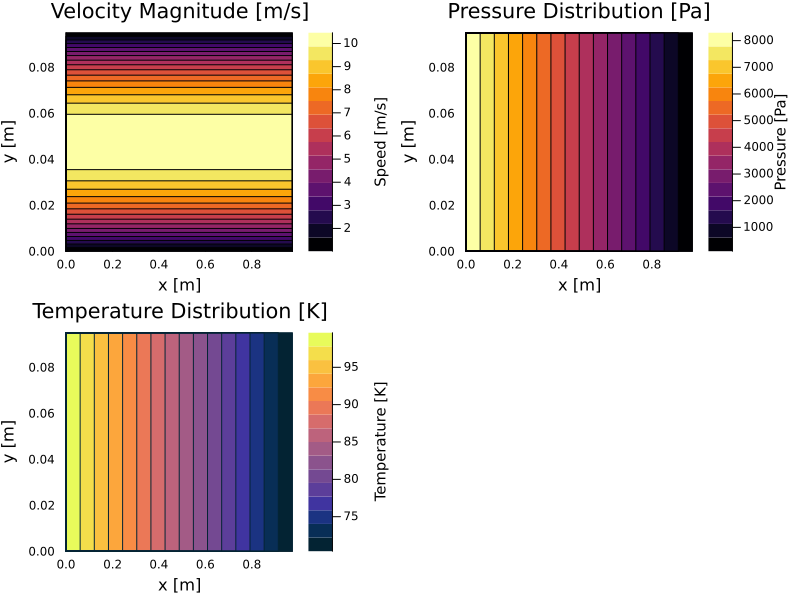

Creating visualizations...
✓ All visualizations created

✓ All visualizations created


In [225]:
# Convert to 2D arrays for plotting (reshape based on mesh structure)
vel_x_2d = reshape(vel_x, nels)
vel_y_2d = reshape(vel_y, nels) 
vel_mag_2d = reshape(vel_mag, nels)
pressure_2d = reshape(pressure, nels)
temperature_2d = reshape(temperature, nels)

# Create comprehensive visualization
println("Creating visualizations...")

# Plot 1: Velocity magnitude  
p1 = contour(xgrid[1:end-1], ygrid[1:end-1], vel_mag_2d',
            fill=true, title="Velocity Magnitude [m/s]",
            xlabel="x [m]", ylabel="y [m]", colorbar_title="Speed [m/s]")

# Plot 2: Pressure distribution
p2 = contour(xgrid[1:end-1], ygrid[1:end-1], pressure_2d', 
            fill=true, title="Pressure Distribution [Pa]",
            xlabel="x [m]", ylabel="y [m]", colorbar_title="Pressure [Pa]")

# Plot 3: Temperature distribution  
p3 = contour(xgrid[1:end-1], ygrid[1:end-1], temperature_2d',
            fill=true, title="Temperature Distribution [K]", 
            xlabel="x [m]", ylabel="y [m]", colorbar_title="Temperature [K]",
            color=:thermal)

# Combine plots
plot_combined = plot(p1, p2, p3, layout=(2,2), size=(800, 600))
display(plot_combined)

println("✓ All visualizations created")

## Section 7: Comparison with Decoupled Approach


In [226]:
# #..geomettry parameters 
# L = 1. 
# H = 0.1
# nels  = (40, 20) # number of elements in each spatial direction
# left  = Vec((0., 0.))  # start point for geometry 
# right = Vec((L, H,))   # end point for geometry
# grid = generate_grid(Quadrilateral,nels,left,right);
# #..mesh in x-direction and y-direction - intended for debugging 
# xgrid = Vector(range(0, L, step=L/nels[1]))
# ygrid = Vector(range(0, H, step=H/nels[2]))
# #..lower left grid node - intended for pressure constraint. 
# addvertexset!(grid, "corner", (x) -> x[1] ≈ 0.0 && x[2] ≈ 0.0)

# function assemble_mass_matrix(cellvalues_v::CellValues, cellvalues_p::CellValues, M::SparseMatrixCSC, dh::DofHandler)
#     # Allocate a buffer for the local matrix and some helpers, together with the assembler.
#     n_basefuncs_v = getnbasefunctions(cellvalues_v)
#     n_basefuncs_p = getnbasefunctions(cellvalues_p)
#     n_basefuncs = n_basefuncs_v + n_basefuncs_p
#     v▄, p▄ = 1, 2
#     Mₑ = BlockedArray(zeros(n_basefuncs, n_basefuncs), [n_basefuncs_v, n_basefuncs_p], [n_basefuncs_v, n_basefuncs_p])

#     # It follows the assembly loop as explained in the basic tutorials.
#     mass_assembler = start_assemble(M)
#     for cell in CellIterator(dh)
#         fill!(Mₑ, 0)
#         Ferrite.reinit!(cellvalues_v, cell)

#         for q_point in 1:getnquadpoints(cellvalues_v)
#             dΩ = getdetJdV(cellvalues_v, q_point)
#             # Remember that we assemble a vector mass term, hence the dot product.
#             # There is only one time derivative on the left hand side, so only one mass block is non-zero.
#             for i in 1:n_basefuncs_v
#                 φᵢ = shape_value(cellvalues_v, q_point, i)
#                 for j in 1:n_basefuncs_v
#                     φⱼ = shape_value(cellvalues_v, q_point, j)
#                     Mₑ[BlockIndex((v▄, v▄), (i, j))] += φᵢ ⋅ φⱼ * dΩ
#                 end
#             end
#         end
#         assemble!(mass_assembler, celldofs(cell), Mₑ)
#     end

#     return M
# end;

# function assemble_stokes_matrix(cellvalues_v::CellValues, cellvalues_p::CellValues, ν, K::SparseMatrixCSC, dh::DofHandler)
#     # Again, some buffers and helpers
#     n_basefuncs_v = getnbasefunctions(cellvalues_v)
#     n_basefuncs_p = getnbasefunctions(cellvalues_p)
#     n_basefuncs = n_basefuncs_v + n_basefuncs_p
#     v▄, p▄ = 1, 2
#     Kₑ = BlockedArray(zeros(n_basefuncs, n_basefuncs), [n_basefuncs_v, n_basefuncs_p], [n_basefuncs_v, n_basefuncs_p])

#     # Assembly loop
#     stiffness_assembler = start_assemble(K)
#     for cell in CellIterator(dh)
#         # Don't forget to initialize everything
#         fill!(Kₑ, 0)

#         Ferrite.reinit!(cellvalues_v, cell)
#         Ferrite.reinit!(cellvalues_p, cell)

#         for q_point in 1:getnquadpoints(cellvalues_v)
#             dΩ = getdetJdV(cellvalues_v, q_point)

#             for i in 1:n_basefuncs_v
#                 ∇φᵢ = shape_gradient(cellvalues_v, q_point, i)
#                 for j in 1:n_basefuncs_v
#                     ∇φⱼ = shape_gradient(cellvalues_v, q_point, j)
#                     Kₑ[BlockIndex((v▄, v▄), (i, j))] -= ν * ∇φᵢ ⊡ ∇φⱼ * dΩ
#                 end
#             end

#             for j in 1:n_basefuncs_p
#                 ψ = shape_value(cellvalues_p, q_point, j)
#                 for i in 1:n_basefuncs_v
#                     divφ = shape_divergence(cellvalues_v, q_point, i)
#                     Kₑ[BlockIndex((v▄, p▄), (i, j))] += (divφ * ψ) * dΩ
#                     Kₑ[BlockIndex((p▄, v▄), (j, i))] += (ψ * divφ) * dΩ
#                 end
#             end
#         end

#         # Assemble `Kₑ` into the Stokes matrix `K`.
#         assemble!(stiffness_assembler, celldofs(cell), Kₑ)
#     end
#     return K
# end;
# dim = 2 
# degree = 2

# ip_v = Lagrange{RefQuadrilateral, 2}()^dim
# qr = QuadratureRule{RefQuadrilateral}(4)
# cellvalues_v = CellValues(qr, ip_v);

# ip_p = Lagrange{RefQuadrilateral, 1}()
# cellvalues_p = CellValues(qr, ip_p);

# dh = DofHandler(grid)
# add!(dh, :v, ip_v)
# add!(dh, :p, ip_p)
# close!(dh);

# ch = ConstraintHandler(dh);

# # Ramp the inlet velocity 
# vmax = 1.5 
# vin(t) = min(t * vmax, vmax) #inflow velocity
# parabolic_inflow_profile(x,t) = Vec((vin(t)*4*x[2]*(H - x[2])/H^2, 0.0))

# # Case-(1/3)
# if (true)
#     # Inlet: Boundary conditions part (1/3): Dirichlet BC for the velocity at the left patch 
#     inlet = getfacetset(dh.grid, "left")
#     dbc1 = Dirichlet(:v, inlet, (x,t) ->  parabolic_inflow_profile(x,t) )
#     add!(ch, dbc1)

#     # Walls: Boundary conditions part (2/3): no slip boundary condition - impose velocity to be zero vector on the walls   
#     wall = union(
#         getfacetset(grid, "top"),
#         # getfacetset(grid, "right"),
#         getfacetset(grid, "bottom"), 
#     )
#     dbc2 = Dirichlet(:v, wall, (x, t) -> [0, 0])
#     add!(ch, dbc2)
    
#     # Boundary conditions part (3/3): apply pressure constraint
#     dbc3 = Dirichlet(:p, getfacetset(grid, "right"), (x, t) -> 1)
#     add!(ch, dbc3)
# end 

# ∂Ω_free = getfacetset(grid, "right");

# close!(ch)
# update!(ch, 0.0);

# viscosity = 1e0 # 1.0 / 1000.0; #dynamic viscosity
# K = allocate_matrix(dh);
# K = assemble_stokes_matrix(cellvalues_v, cellvalues_p, viscosity, K, dh);

# M = allocate_matrix(dh);
# M = assemble_mass_matrix(cellvalues_v, cellvalues_p, M, dh);

# f = zeros(ndofs(dh));
# T = 6.0
# Δt₀ = 0.001
# Δt_save = 0.1
# ν = viscosity

# K = allocate_matrix(dh);
# K = assemble_stokes_matrix(cellvalues_v, cellvalues_p, ν, K, dh);

# M = allocate_matrix(dh);
# M = assemble_mass_matrix(cellvalues_v, cellvalues_p, M, dh);

# u₀ = zeros(ndofs(dh))
# apply!(u₀, ch);

# jac_sparsity = sparse(K);

# apply!(M, ch)

# struct RHSparams
#     K::SparseMatrixCSC
#     ch::ConstraintHandler
#     dh::DofHandler
#     cellvalues_v::CellValues
#     u::Vector
# end
# p = RHSparams(K, ch, dh, cellvalues_v, copy(u₀))

# function ferrite_limiter!(u, _, p, t)
#     update!(p.ch, t)
#     return apply!(u, p.ch)
# end

# function navierstokes_rhs_element!(dvₑ, vₑ, cellvalues_v)
#     n_basefuncs = getnbasefunctions(cellvalues_v)
#     for q_point in 1:getnquadpoints(cellvalues_v)
#         dΩ = getdetJdV(cellvalues_v, q_point)
#         ∇v = function_gradient(cellvalues_v, q_point, vₑ)
#         v = function_value(cellvalues_v, q_point, vₑ)
#         for j in 1:n_basefuncs
#             φⱼ = shape_value(cellvalues_v, q_point, j)

#             dvₑ[j] -= v ⋅ ∇v' ⋅ φⱼ * dΩ
#         end
#     end
#     return
# end

# function stokes!(du, u_uc, p::RHSparams, t)

#     @unpack K, ch, dh, cellvalues_v, u = p

#     u .= u_uc
#     update!(ch, t)
#     apply!(u, ch)

#     # Linear contribution (Stokes operator)
#     mul!(du, K, u) # du .= K * u

#     return
# end;

# function navierstokes!(du, u_uc, p::RHSparams, t)

#     @unpack K, ch, dh, cellvalues_v, u = p

#     u .= u_uc
#     update!(ch, t)
#     apply!(u, ch)

#     # Linear contribution (Stokes operator)
#     mul!(du, K, u) # du .= K * u

#     # nonlinear contribution
#     v_range = dof_range(dh, :v)
#     n_basefuncs = getnbasefunctions(cellvalues_v)
#     vₑ = zeros(n_basefuncs)
#     duₑ = zeros(n_basefuncs)
#     for cell in CellIterator(dh)
#         Ferrite.reinit!(cellvalues_v, cell)
#         v_celldofs = @view celldofs(cell)[v_range]
#         vₑ .= @views u[v_celldofs]
#         fill!(duₑ, 0.0)
#         navierstokes_rhs_element!(duₑ, vₑ, cellvalues_v)
#         assemble!(du, v_celldofs, duₑ)
#     end
#     return
# end;

# function navierstokes_jac_element!(Jₑ, vₑ, cellvalues_v)
#     n_basefuncs = getnbasefunctions(cellvalues_v)
#     for q_point in 1:getnquadpoints(cellvalues_v)
#         dΩ = getdetJdV(cellvalues_v, q_point)
#         ∇v = function_gradient(cellvalues_v, q_point, vₑ)
#         v = function_value(cellvalues_v, q_point, vₑ)
#         for j in 1:n_basefuncs
#             φⱼ = shape_value(cellvalues_v, q_point, j)

#             for i in 1:n_basefuncs
#                 φᵢ = shape_value(cellvalues_v, q_point, i)
#                 ∇φᵢ = shape_gradient(cellvalues_v, q_point, i)
#                 Jₑ[j, i] -= (φᵢ ⋅ ∇v' + v ⋅ ∇φᵢ') ⋅ φⱼ * dΩ
#             end
#         end
#     end
#     return
# end

# function stokes_jac!(J, u_uc, p, t)

#     @unpack K, ch, dh, cellvalues_v, u = p

#     u .= u_uc
#     update!(ch, t)
#     apply!(u, ch)

#     # Linear contribution (Stokes operator)
#     # Here we assume that J has exactly the same structure as K by construction
#     nonzeros(J) .= nonzeros(K)

#     assembler = start_assemble(J; fillzero = false)

#     return apply!(J, ch)
# end;

# function navierstokes_jac!(J, u_uc, p, t)

#     @unpack K, ch, dh, cellvalues_v, u = p

#     u .= u_uc
#     update!(ch, t)
#     apply!(u, ch)

#     # Linear contribution (Stokes operator)
#     # Here we assume that J has exactly the same structure as K by construction
#     nonzeros(J) .= nonzeros(K)

#     assembler = start_assemble(J; fillzero = false)

#     # Assemble variation of the nonlinear term
#     n_basefuncs = getnbasefunctions(cellvalues_v)
#     Jₑ = zeros(n_basefuncs, n_basefuncs)
#     vₑ = zeros(n_basefuncs)
#     v_range = dof_range(dh, :v)
#     for cell in CellIterator(dh)
#         Ferrite.reinit!(cellvalues_v, cell)
#         v_celldofs = @view celldofs(cell)[v_range]

#         vₑ .= @views u[v_celldofs]
#         fill!(Jₑ, 0.0)
#         navierstokes_jac_element!(Jₑ, vₑ, cellvalues_v)
#         assemble!(assembler, v_celldofs, Jₑ)
#     end

#     return apply!(J, ch)
# end;

# st_rhs = ODEFunction(stokes!, mass_matrix=M; jac=navierstokes_jac!, jac_prototype=jac_sparsity)
# st_problem = ODEProblem(st_rhs, u₀, (0.0,T), p);

# ns_rhs = ODEFunction(navierstokes!, mass_matrix=M; jac=navierstokes_jac!, jac_prototype=jac_sparsity)
# ns_problem = ODEProblem(ns_rhs, u₀, (0.0,T), p);

# struct FreeDofErrorNorm
#     ch::ConstraintHandler
# end
# (fe_norm::FreeDofErrorNorm)(u::Union{AbstractFloat, Complex}, t) = DiffEqBase.ODE_DEFAULT_NORM(u, t)
# (fe_norm::FreeDofErrorNorm)(u::AbstractArray, t) = DiffEqBase.ODE_DEFAULT_NORM(u[fe_norm.ch.free_dofs], t)

# timestepper = Rodas5P(autodiff=false, step_limiter! = ferrite_limiter!);

# integrator = init(
#     st_problem, timestepper; initializealg=NoInit(), dt=Δt₀,
#     adaptive=true, abstol=1e-4, reltol=1e-5,
#     progress=true, progress_steps=1,
#     verbose=true, internalnorm=FreeDofErrorNorm(ch), d_discontinuities=[1.0]
# );

# pvd = paraview_collection("vortex-street")
# for (step, (u,t)) in enumerate(intervals(integrator))
#     VTKGridFile("vortex-street-$step", dh) do vtk
#         write_solution(vtk, dh, u)
#         pvd[t] = vtk
#     end
# end
# vtk_save(pvd);
# st_sol = solve(
#     st_problem, timestepper; initializealg=NoInit(), dt=Δt₀,
#     adaptive=true, abstol=1e-4, reltol=1e-5,
#     progress=true, progress_steps=1,
#     verbose=true, internalnorm=FreeDofErrorNorm(ch), d_discontinuities=[1.0]
# );

In [227]:
# function assemble_temp_system!(K, dh_temp, cv_temp, dh_flow, cv_flow, flow_solution, α)
#     """
#     Assemble system matrix for the temperature transport equation (post-processing):
#     (u⃗ · ∇)T = α ∇²T  (steady state, no heat source)
    
#     This function assembles the convection-diffusion matrix for temperature transport
#     using a pre-computed velocity field from the Navier-Stokes solution.
    
#     Parameters:
#     - K: Global system matrix for temperature (to be assembled)
#     - dh_temp: DOF handler for temperature field (separate from flow)
#     - cv_temp: Cell values for temperature field
#     - dh_flow: DOF handler for flow field (velocity + pressure)
#     - cv_flow: Cell values for velocity field
#     - flow_solution: Solution vector from Navier-Stokes (contains velocity + pressure)
#     - α: Thermal diffusivity [m²/s]
#     """
    
#     assembler = start_assemble(K)
    
#     # Get DOF ranges
#     range_temp = dof_range(dh_temp, :T)      # Temperature DOFs
#     range_vel = dof_range(dh_flow, :v)       # Velocity DOFs from flow solution
    
#     ndofs_temp = length(range_temp)
#     Ke = zeros(ndofs_temp, ndofs_temp)
    
#     # Shape function storage for temperature
#     T_shape = Vector{Float64}(undef, ndofs_temp)
#     ∇T_shape = Vector{Vec{2,Float64}}(undef, ndofs_temp)
    
#     # Loop over all cells
#     for (cell_num, cell) in enumerate(CellIterator(dh_temp))
#         fill!(Ke, 0)
        
#         # Reinitialize cell values for temperature field
#         Ferrite.reinit!(cv_temp, cell)
        
#         # Extract velocity DOFs for this cell from the flow solution
#         vel_dofs_local = flow_solution[celldofs(dh_flow, cell_num)[range_vel]]
        
#         # Loop over quadrature points
#         for qp in 1:getnquadpoints(cv_temp)
#             dΩ = getdetJdV(cv_temp, qp)
            
#             # Get temperature shape functions and gradients
#             for i in 1:ndofs_temp
#                 T_shape[i] = shape_value(cv_temp, qp, i)
#                 ∇T_shape[i] = shape_gradient(cv_temp, qp, i)
#             end
            
#             # Interpolate velocity at this quadrature point using flow cell values
#             vel_qp = function_value(cv_flow, qp, vel_dofs_local)
            
#             # Assemble element matrix
#             for (i, I) in pairs(range_temp), (j, J) in pairs(range_temp)
#                 # Thermal diffusion term: α ∇T_i · ∇T_j
#                 diffusion_term = α * (∇T_shape[i] ⋅ ∇T_shape[j])
                
#                 # Thermal convection term: (u⃗ · ∇T_i) * T_j
#                 convection_term = (vel_qp ⋅ ∇T_shape[j]) * T_shape[i]
                
                
#                 # Add both terms to element matrix
#                 Ke[I, J] += (diffusion_term + 0*convection_term) * dΩ
#             end
#         end
        
#         # Assemble element matrix into global matrix
#         assemble!(assembler, celldofs(cell), Ke)
#     end
    
#     return K
# end

# # =============================================================================
# # DECOUPLED TEMPERATURE TRANSPORT IMPLEMENTATION
# # =============================================================================

# # 1. MATERIAL PROPERTIES FOR TEMPERATURE TRANSPORT

# ρ = 1.0                    # Density [kg/m³]
# cp = 1005.0                # Specific heat capacity [J/(kg·K)]
# k_thermal = 2500          # Thermal conductivity [W/(m·K)]
# α = k_thermal / (ρ * cp)   # Thermal diffusivity [m²/s]


# # 2. SEPARATE DOF HANDLER FOR TEMPERATURE (Key requirement from supervisor)
# println("\n Setting up separate DOF handler for temperature:")

# # Temperature finite element setup
# degree_temp = 2  # Same as velocity for consistency and accuracy
# ip_temp = Lagrange{RefQuadrilateral, degree_temp}()

# # Temperature cell values
# qr_temp = QuadratureRule{RefQuadrilateral}(4)     
# cv_temp = CellValues(qr_temp, ip_temp)

# # SEPARATE DOF HANDLER for temperature 
# dh_temp = DofHandler(grid)                    # Same mesh, different DOF handler
# add!(dh_temp, :T, ip_temp)                   
# close!(dh_temp)


# # 3. TEMPERATURE BOUNDARY CONDITIONS
# println("\n Setting up temperature boundary conditions:")

# ch_temp = ConstraintHandler(dh_temp)

# # Inlet temperature boundary condition
# T_inlet = 100.0  # [K] Hot fluid at inlet
# # T_walls = 70.0  # [K] Wall temperature (ambient)
# T_outlet = 70.0

# # Inlet BC: Hot fluid injection
# dbc_inlet_temp = Dirichlet(:T, inlet, x -> T_inlet)
# add!(ch_temp, dbc_inlet_temp)

# # # Wall BC: Fixed temperature at walls (optional - can use natural BC instead)
# # walls = union(getfacetset(grid, "top"), getfacetset(grid, "bottom"))
# # dbc_wall_temp = Dirichlet(:T, walls, x -> T_walls)
# # add!(ch_temp, dbc_wall_temp)

# dbc_outlet_temp = Dirichlet(:T, ∂Ω_free, x -> T_outlet)
# add!(ch_temp, dbc_outlet_temp)  


# close!(ch_temp)

# # println("   Inlet temperature: $T_inlet K")
# # println("   Wall temperature: $T_walls K")

# # 4. CHECK FLOW SOLUTION AVAILABILITY
# println("\n Checking flow solution:")

# if @isdefined(st_sol)
#     println("   ✓ Using time-dependent flow solution from Navier-Stokes")
#     u_flow = st_sol.u[end]  # Final time step
#     # println("   ✓ Flow solution vector length: $(length(u_flow))")
# else
#     println("   ⚠ Time-dependent solution not available")
#     println("   → Computing stationary Stokes solution for demonstration")
    
#     # Solve stationary Stokes for temperature demonstration
#     K_stokes = allocate_matrix(dh)
#     K_stokes = assemble_stokes_matrix(cellvalues_v, cellvalues_p, viscosity, K_stokes, dh)
#     f_stokes = zeros(ndofs(dh))
    
#     t_stat = 1.0
#     update!(ch, t_stat)
#     apply!(K_stokes, f_stokes, ch)
    
#     u_flow = K_stokes \ f_stokes
#     println("   ✓ Stationary solution computed")
# end

# # 5. ASSEMBLE TEMPERATURE SYSTEM
# println("\n Assembling temperature transport system:")

# K_temp = allocate_matrix(dh_temp, ch_temp)
# f_temp = zeros(ndofs(dh_temp))  # Zero RHS (no heat source)

# # Assemble using the decoupled approach
# assemble_temp_system!(K_temp, dh_temp, cv_temp, dh, cellvalues_v, u_flow, α)

# println("   ✓ Temperature system matrix assembled")

# # Apply boundary conditions
# apply!(K_temp, f_temp, ch_temp)

# println("   ✓ Boundary conditions applied")

# # 6. SOLVE TEMPERATURE SYSTEM
# println("\n Solving temperature transport equation:")

# T_solution = K_temp \ f_temp


# # Custom post-processing function for temperature
# function temp_postprocess(T_sol, dh_temp, cv_temp)
#     area = []
#     temp_values = []
    
#     for (cell_num, cell) in enumerate(CellIterator(dh_temp))
#         dof_range_temp = dof_range(dh_temp, :T)
#         T_local = T_sol[celldofs(dh_temp, cell_num)[dof_range_temp]]
#         Ferrite.reinit!(cv_temp, cell)
        
#         cell_area = 0.0
#         cell_temp = 0.0
        
#         for qp in 1:getnquadpoints(cv_temp)
#             dΩ = getdetJdV(cv_temp, qp)
#             temp_contrib = function_value(cv_temp, qp, T_local)
#             cell_area += dΩ
#             cell_temp += temp_contrib * dΩ
#         end
        
#         push!(area, cell_area)
#         push!(temp_values, cell_temp / cell_area)
#     end
    
#     temp_2d = reshape(temp_values, nels)
#     return area, temp_2d
# end

# # Process temperature solution
# area_temp, temp2d = temp_postprocess(T_solution, dh_temp, cv_temp)


# # Create visualization
# plot_temp = contour(xgrid[1:end-1], ygrid[1:end-1], temp2d', 
#                    fill=true, 
#                    title="Temperature Distribution (Decoupled Approach)",
#                    xlabel="x [m]", 
#                    ylabel="y [m]",
#                    colorbar_title="Temperature [K]")

# display(plot_temp)




### Comparison plot

In [228]:
# centerline_indices = div(nels[2], 2) + 1  # Middle row
# T_centerline_coupled = temperature_2d[:, centerline_indices] 
# x_centerline = xgrid[1:end-1]
# t_original_decoupled = temp2d[:, centerline_indices]

# # plot comparison of the decoupled and coupled temperature along centerline
# p_compare = plot(x_centerline, T_centerline_coupled, label="Coupled", lw=2)
# plot!(p_compare, x_centerline, t_original_decoupled, label="Decoupled", lw=2, ls=:dash)
# xlabel!(p_compare, "x [m]")
# ylabel!(p_compare, "Temperature [K]")
# title!(p_compare, "Centerline Temperature Comparison")
# display(p_compare)



## Section 8: Extended Coupled System with Convective Temperature Transport

### Mathematical Framework with Convection

So far, we have implemented a coupled system where the temperature equation only includes diffusion:

$$-\alpha \nabla^2 T = 0$$

Now we extend this to include **convective heat transport**:

$$(\mathbf{u} \cdot \nabla) T - \alpha \nabla^2 T = 0$$

This creates a **velocity-temperature coupling** in the system matrix.

### Extended System Matrix Structure

The system matrix now has the following structure:

$$\mathbf{K}_{\text{conv}} = \begin{bmatrix}
\mathbf{A} & \mathbf{B} & \mathbf{0} \\
\mathbf{B}^T & \mathbf{0} & \mathbf{0} \\
\mathbf{D} & \mathbf{0} & \mathbf{C} + \mathbf{E}
\end{bmatrix}$$


In [230]:
function assemble_coupled_stokes_temperature_convective!(K, dh, cellvalues_v, cellvalues_p, cellvalues_T, ν, α, u_ref)
    """
    Assemble the coupled Stokes-temperature system matrix WITH convective terms.
    
    Extended matrix structure:
    [A B 0]   [u]   [b1]
    [B' 0 0] * [p] = [0 ]  
    [D 0 C+E] [T]   [b3]
    
    Where:
    - A: Viscous operator (velocity-velocity coupling) 
    - B: Divergence operator (velocity-pressure coupling)
    - C: Diffusion operator (temperature-temperature coupling)
    - D: NEW - Velocity-temperature convection coupling
    - E: NEW - Temperature convection operator (using reference velocity)
    
    Parameters:
    - u_ref: Reference velocity field for linearization of convective terms
    """
    
    # Get DOF information
    n_basefuncs_v = getnbasefunctions(cellvalues_v)
    n_basefuncs_p = getnbasefunctions(cellvalues_p)  
    n_basefuncs_T = getnbasefunctions(cellvalues_T)
    n_basefuncs_total = n_basefuncs_v + n_basefuncs_p + n_basefuncs_T
    
    # Define block indices for assembly
    v_block, p_block, T_block = 1, 2, 3
    
    # Create blocked element matrix  
    Ke = BlockedArray(zeros(n_basefuncs_total, n_basefuncs_total), 
                      [n_basefuncs_v, n_basefuncs_p, n_basefuncs_T],
                      [n_basefuncs_v, n_basefuncs_p, n_basefuncs_T])
    
    # Start assembly
    assembler = start_assemble(K)
    
    # DOF ranges for extracting velocity
    v_range = dof_range(dh, :v)
    
    # Loop over all elements
    for (cell_num, cell) in enumerate(CellIterator(dh))
        # Reset element matrix
        fill!(Ke, 0)
        
        # Reinitialize cell values for current element
        Ferrite.reinit!(cellvalues_v, cell)
        Ferrite.reinit!(cellvalues_p, cell) 
        Ferrite.reinit!(cellvalues_T, cell)
        
        # Extract reference velocity DOFs for this element
        u_ref_local = u_ref[celldofs(cell)[v_range]]
        
        # Loop over quadrature points
        for qp in 1:getnquadpoints(cellvalues_v)
            dΩ = getdetJdV(cellvalues_v, qp)
            
            # =============================================================
            # BLOCK A: Velocity-Velocity (Viscous operator) - UNCHANGED
            # A_ij = ∫ ν ∇φᵢ : ∇φⱼ dΩ  
            # =============================================================
            for i in 1:n_basefuncs_v
                ∇φᵢ = shape_gradient(cellvalues_v, qp, i)
                for j in 1:n_basefuncs_v
                    ∇φⱼ = shape_gradient(cellvalues_v, qp, j)
                    Ke[BlockIndex((v_block, v_block), (i, j))] += ν * (∇φᵢ ⊡ ∇φⱼ) * dΩ
                end
            end
            
            # =============================================================  
            # BLOCK B: Velocity-Pressure (Divergence operator) - UNCHANGED
            # B_ij = ∫ (∇·φᵢ) ψⱼ dΩ
            # =============================================================
            for i in 1:n_basefuncs_v
                divφᵢ = shape_divergence(cellvalues_v, qp, i)
                for j in 1:n_basefuncs_p
                    ψⱼ = shape_value(cellvalues_p, qp, j)
                    # B block: velocity-pressure coupling
                    Ke[BlockIndex((v_block, p_block), (i, j))] -= divφᵢ * ψⱼ * dΩ
                    # B^T block: pressure-velocity coupling  
                    Ke[BlockIndex((p_block, v_block), (j, i))] -= ψⱼ * divφᵢ * dΩ
                end
            end
            
            # =============================================================
            # BLOCK D: NEW - Velocity-Temperature Convection Coupling
            # D_ij = ∫ χⱼ (φᵢ · ∇) T_ref dΩ
            # Note: This coupling would require knowing T_ref, so we skip it
            # for this linearized approach and focus on Block E
            # =============================================================
            
        end
        
        # Loop over quadrature points for temperature
        for qp in 1:getnquadpoints(cellvalues_T)
            dΩ = getdetJdV(cellvalues_T, qp)
            
            # Interpolate reference velocity at this quadrature point
            u_ref_qp = function_value(cellvalues_v, qp, u_ref_local)
            
            # =============================================================
            # BLOCK C: Temperature-Temperature (Diffusion operator) - UNCHANGED
            # C_ij = ∫ α ∇χᵢ · ∇χⱼ dΩ
            # =============================================================
            for i in 1:n_basefuncs_T
                ∇χᵢ = shape_gradient(cellvalues_T, qp, i)
                for j in 1:n_basefuncs_T
                    ∇χⱼ = shape_gradient(cellvalues_T, qp, j)
                    Ke[BlockIndex((T_block, T_block), (i, j))] += α * (∇χᵢ ⋅ ∇χⱼ) * dΩ
                end
            end
            
            # =============================================================
            # BLOCK E: NEW - Temperature Convection Operator
            # E_ij = ∫ χᵢ (u_ref · ∇χⱼ) dΩ
            # =============================================================
            for i in 1:n_basefuncs_T
                χᵢ = shape_value(cellvalues_T, qp, i)
                for j in 1:n_basefuncs_T
                    ∇χⱼ = shape_gradient(cellvalues_T, qp, j)
                    # Convective term: test function × (velocity · gradient of trial function)
                    convection_term = χᵢ * (u_ref_qp ⋅ ∇χⱼ)
                    Ke[BlockIndex((T_block, T_block), (i, j))] += convection_term * dΩ
                end
            end
        end
        
        # Assemble element matrix into global matrix
        assemble!(assembler, celldofs(cell), Ke)
    end
    
    return K
end

println("✓ Extended assembly function with convective terms defined")

✓ Extended assembly function with convective terms defined


In [231]:
# Solve the convective system using the previous solution as reference velocity
println("Solving extended system with convective temperature transport...")

# Allocate new system matrix and RHS for convective case
K_conv = allocate_matrix(dh)
f_conv = zeros(ndofs(dh))

# Use the previous solution (diffusion-only) as reference velocity for linearization
u_reference = solution  # This contains [velocity, pressure, temperature] from previous solve

println("  Using previous solution as reference velocity field")
println("  Reference velocity range: [$(minimum(u_reference[dof_range(dh, :v)])), $(maximum(u_reference[dof_range(dh, :v)]))]")

# Assemble the extended system with convective terms
assemble_coupled_stokes_temperature_convective!(K_conv, dh, cellvalues_v, cellvalues_p, cellvalues_T, ν, α, u_reference)

println("✓ Extended system matrix assembled with convective terms")

# Apply boundary conditions (same as before)
apply!(K_conv, f_conv, ch)

println("✓ Boundary conditions applied to extended system")

# Solve the extended system
println("Solving extended linear system...")
@time solution_conv = K_conv \ f_conv

println("✓ Extended system solved successfully")

# Extract field solutions
velocity_conv = solution_conv[dof_range(dh, :v)]
pressure_conv = solution_conv[dof_range(dh, :p)]
temperature_conv = solution_conv[dof_range(dh, :T)]

println("  Extended solution ranges:")
println("    Velocity: [$(minimum(velocity_conv)), $(maximum(velocity_conv))]")
println("    Pressure: [$(minimum(pressure_conv)), $(maximum(pressure_conv))]") 
println("    Temperature: [$(minimum(temperature_conv)), $(maximum(temperature_conv))]")

Solving extended system with convective temperature transport...
  Using previous solution as reference velocity field
  Reference velocity range: [-4.873551965888747e-15, 1.9950000000000598]
✓ Extended system matrix assembled with convective terms
✓ Boundary conditions applied to extended system
Solving extended linear system...
  0.166879 seconds (86 allocations: 58.692 MiB)
✓ Extended system solved successfully
  Extended solution ranges:
    Velocity: [-4.873551965888747e-15, 1.9950000000000598]
    Pressure: [8189.999999999919, 8399.99999999993]
    Temperature: [99.8581992833093, 100.00000000000001]
✓ Extended system matrix assembled with convective terms
✓ Boundary conditions applied to extended system
Solving extended linear system...
  0.166879 seconds (86 allocations: 58.692 MiB)
✓ Extended system solved successfully
  Extended solution ranges:
    Velocity: [-4.873551965888747e-15, 1.9950000000000598]
    Pressure: [8189.999999999919, 8399.99999999993]
    Temperature: [99.8

In [232]:
# Post-process the convective solution
println("Post-processing convective solution...")
vel_x_conv, vel_y_conv, vel_mag_conv, pressure_conv_pp, temperature_conv_pp, areas_conv = postprocess_coupled_solution(
    solution_conv, dh, cellvalues_v, cellvalues_p, cellvalues_T)

# Convert to 2D arrays for plotting
vel_x_conv_2d = reshape(vel_x_conv, nels)
vel_y_conv_2d = reshape(vel_y_conv, nels) 
vel_mag_conv_2d = reshape(vel_mag_conv, nels)
pressure_conv_2d = reshape(pressure_conv_pp, nels)
temperature_conv_2d = reshape(temperature_conv_pp, nels)

println("✓ Convective solution post-processed")
println("  Convective temperature range: [$(minimum(temperature_conv_2d)), $(maximum(temperature_conv_2d))] K")

Post-processing convective solution...
✓ Convective solution post-processed
  Convective temperature range: [71.07685342475916, 99.9321348919684] K


### Comprehensive Comparison: Diffusion vs Convective Temperature Transport

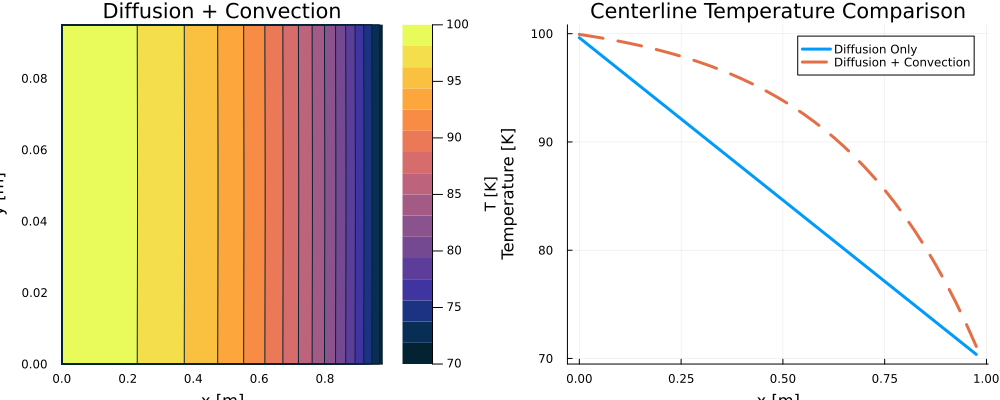

In [233]:

# Extract centerline data for both cases
centerline_indices = div(nels[2], 2) + 1  # Middle row
T_centerline_diffusion = temperature_2d[:, centerline_indices] 
T_centerline_convective = temperature_conv_2d[:, centerline_indices]
x_centerline = xgrid[1:end-1]


p_conv = contour(xgrid[1:end-1], ygrid[1:end-1], temperature_conv_2d',
                fill=true, title="Diffusion + Convection",
                xlabel="x [m]", ylabel="y [m]", colorbar_title="T [K]", 
                color=:thermal, clims=(T_outlet, T_inlet))


# Centerline temperature comparison
p_centerline = plot(x_centerline, T_centerline_diffusion, 
                   label="Diffusion Only", linewidth=3, linestyle=:solid,
                   xlabel="x [m]", ylabel="Temperature [K]", 
                   title="Centerline Temperature Comparison")
plot!(p_centerline, x_centerline, T_centerline_convective, 
      label="Diffusion + Convection", linewidth=3, linestyle=:dash)

# Combined visualization  
plot_comparison = plot(p_conv, p_centerline, 
                      layout=(1,2), size=(1000, 400))
display(plot_comparison)




### Comparison with decoupled approach

In [237]:
#..geomettry parameters 
L = 1. 
H = 0.1
nels  = (40, 20) # number of elements in each spatial direction
left  = Vec((0., 0.))  # start point for geometry 
right = Vec((L, H,))   # end point for geometry
grid = generate_grid(Quadrilateral,nels,left,right);
#..mesh in x-direction and y-direction - intended for debugging 
xgrid = Vector(range(0, L, step=L/nels[1]))
ygrid = Vector(range(0, H, step=H/nels[2]))
#..lower left grid node - intended for pressure constraint. 
addvertexset!(grid, "corner", (x) -> x[1] ≈ 0.0 && x[2] ≈ 0.0)

function assemble_mass_matrix(cellvalues_v::CellValues, cellvalues_p::CellValues, M::SparseMatrixCSC, dh::DofHandler)
    # Allocate a buffer for the local matrix and some helpers, together with the assembler.
    n_basefuncs_v = getnbasefunctions(cellvalues_v)
    n_basefuncs_p = getnbasefunctions(cellvalues_p)
    n_basefuncs = n_basefuncs_v + n_basefuncs_p
    v▄, p▄ = 1, 2
    Mₑ = BlockedArray(zeros(n_basefuncs, n_basefuncs), [n_basefuncs_v, n_basefuncs_p], [n_basefuncs_v, n_basefuncs_p])

    # It follows the assembly loop as explained in the basic tutorials.
    mass_assembler = start_assemble(M)
    for cell in CellIterator(dh)
        fill!(Mₑ, 0)
        Ferrite.reinit!(cellvalues_v, cell)

        for q_point in 1:getnquadpoints(cellvalues_v)
            dΩ = getdetJdV(cellvalues_v, q_point)
            # Remember that we assemble a vector mass term, hence the dot product.
            # There is only one time derivative on the left hand side, so only one mass block is non-zero.
            for i in 1:n_basefuncs_v
                φᵢ = shape_value(cellvalues_v, q_point, i)
                for j in 1:n_basefuncs_v
                    φⱼ = shape_value(cellvalues_v, q_point, j)
                    Mₑ[BlockIndex((v▄, v▄), (i, j))] += φᵢ ⋅ φⱼ * dΩ
                end
            end
        end
        assemble!(mass_assembler, celldofs(cell), Mₑ)
    end

    return M
end;

function assemble_stokes_matrix(cellvalues_v::CellValues, cellvalues_p::CellValues, ν, K::SparseMatrixCSC, dh::DofHandler)
    # Again, some buffers and helpers
    n_basefuncs_v = getnbasefunctions(cellvalues_v)
    n_basefuncs_p = getnbasefunctions(cellvalues_p)
    n_basefuncs = n_basefuncs_v + n_basefuncs_p
    v▄, p▄ = 1, 2
    Kₑ = BlockedArray(zeros(n_basefuncs, n_basefuncs), [n_basefuncs_v, n_basefuncs_p], [n_basefuncs_v, n_basefuncs_p])

    # Assembly loop
    stiffness_assembler = start_assemble(K)
    for cell in CellIterator(dh)
        # Don't forget to initialize everything
        fill!(Kₑ, 0)

        Ferrite.reinit!(cellvalues_v, cell)
        Ferrite.reinit!(cellvalues_p, cell)

        for q_point in 1:getnquadpoints(cellvalues_v)
            dΩ = getdetJdV(cellvalues_v, q_point)

            for i in 1:n_basefuncs_v
                ∇φᵢ = shape_gradient(cellvalues_v, q_point, i)
                for j in 1:n_basefuncs_v
                    ∇φⱼ = shape_gradient(cellvalues_v, q_point, j)
                    Kₑ[BlockIndex((v▄, v▄), (i, j))] -= ν * ∇φᵢ ⊡ ∇φⱼ * dΩ
                end
            end

            for j in 1:n_basefuncs_p
                ψ = shape_value(cellvalues_p, q_point, j)
                for i in 1:n_basefuncs_v
                    divφ = shape_divergence(cellvalues_v, q_point, i)
                    Kₑ[BlockIndex((v▄, p▄), (i, j))] += (divφ * ψ) * dΩ
                    Kₑ[BlockIndex((p▄, v▄), (j, i))] += (ψ * divφ) * dΩ
                end
            end
        end

        # Assemble `Kₑ` into the Stokes matrix `K`.
        assemble!(stiffness_assembler, celldofs(cell), Kₑ)
    end
    return K
end;
dim = 2 
degree = 2

ip_v = Lagrange{RefQuadrilateral, 2}()^dim
qr = QuadratureRule{RefQuadrilateral}(4)
cellvalues_v = CellValues(qr, ip_v);

ip_p = Lagrange{RefQuadrilateral, 1}()
cellvalues_p = CellValues(qr, ip_p);

dh = DofHandler(grid)
add!(dh, :v, ip_v)
add!(dh, :p, ip_p)
close!(dh);

ch = ConstraintHandler(dh);

# Ramp the inlet velocity 
vmax = 10.5 
vin(t) = min(t * vmax, vmax) #inflow velocity
parabolic_inflow_profile(x,t) = Vec((vin(t)*4*x[2]*(H - x[2])/H^2, 0.0))

# Case-(1/3)
if (true)
    # Inlet: Boundary conditions part (1/3): Dirichlet BC for the velocity at the left patch 
    inlet = getfacetset(dh.grid, "left")
    dbc1 = Dirichlet(:v, inlet, (x,t) ->  parabolic_inflow_profile(x,t) )
    add!(ch, dbc1)

    # Walls: Boundary conditions part (2/3): no slip boundary condition - impose velocity to be zero vector on the walls   
    wall = union(
        getfacetset(grid, "top"),
        # getfacetset(grid, "right"),
        getfacetset(grid, "bottom"), 
    )
    dbc2 = Dirichlet(:v, wall, (x, t) -> [0, 0])
    add!(ch, dbc2)
    
    # Boundary conditions part (3/3): apply pressure constraint
    dbc3 = Dirichlet(:p, getfacetset(grid, "right"), (x, t) -> 1)
    add!(ch, dbc3)
end 

∂Ω_free = getfacetset(grid, "right");

close!(ch)
update!(ch, 0.0);

viscosity = 1e0 # 1.0 / 1000.0; #dynamic viscosity
K = allocate_matrix(dh);
K = assemble_stokes_matrix(cellvalues_v, cellvalues_p, viscosity, K, dh);

M = allocate_matrix(dh);
M = assemble_mass_matrix(cellvalues_v, cellvalues_p, M, dh);

f = zeros(ndofs(dh));
T = 6.0
Δt₀ = 0.001
Δt_save = 0.1
ν = viscosity

K = allocate_matrix(dh);
K = assemble_stokes_matrix(cellvalues_v, cellvalues_p, ν, K, dh);

M = allocate_matrix(dh);
M = assemble_mass_matrix(cellvalues_v, cellvalues_p, M, dh);

u₀ = zeros(ndofs(dh))
apply!(u₀, ch);

jac_sparsity = sparse(K);

apply!(M, ch)

struct RHSparams
    K::SparseMatrixCSC
    ch::ConstraintHandler
    dh::DofHandler
    cellvalues_v::CellValues
    u::Vector
end
p = RHSparams(K, ch, dh, cellvalues_v, copy(u₀))

function ferrite_limiter!(u, _, p, t)
    update!(p.ch, t)
    return apply!(u, p.ch)
end

function navierstokes_rhs_element!(dvₑ, vₑ, cellvalues_v)
    n_basefuncs = getnbasefunctions(cellvalues_v)
    for q_point in 1:getnquadpoints(cellvalues_v)
        dΩ = getdetJdV(cellvalues_v, q_point)
        ∇v = function_gradient(cellvalues_v, q_point, vₑ)
        v = function_value(cellvalues_v, q_point, vₑ)
        for j in 1:n_basefuncs
            φⱼ = shape_value(cellvalues_v, q_point, j)

            dvₑ[j] -= v ⋅ ∇v' ⋅ φⱼ * dΩ
        end
    end
    return
end

function stokes!(du, u_uc, p::RHSparams, t)

    @unpack K, ch, dh, cellvalues_v, u = p

    u .= u_uc
    update!(ch, t)
    apply!(u, ch)

    # Linear contribution (Stokes operator)
    mul!(du, K, u) # du .= K * u

    return
end;

function navierstokes!(du, u_uc, p::RHSparams, t)

    @unpack K, ch, dh, cellvalues_v, u = p

    u .= u_uc
    update!(ch, t)
    apply!(u, ch)

    # Linear contribution (Stokes operator)
    mul!(du, K, u) # du .= K * u

    # nonlinear contribution
    v_range = dof_range(dh, :v)
    n_basefuncs = getnbasefunctions(cellvalues_v)
    vₑ = zeros(n_basefuncs)
    duₑ = zeros(n_basefuncs)
    for cell in CellIterator(dh)
        Ferrite.reinit!(cellvalues_v, cell)
        v_celldofs = @view celldofs(cell)[v_range]
        vₑ .= @views u[v_celldofs]
        fill!(duₑ, 0.0)
        navierstokes_rhs_element!(duₑ, vₑ, cellvalues_v)
        assemble!(du, v_celldofs, duₑ)
    end
    return
end;

function navierstokes_jac_element!(Jₑ, vₑ, cellvalues_v)
    n_basefuncs = getnbasefunctions(cellvalues_v)
    for q_point in 1:getnquadpoints(cellvalues_v)
        dΩ = getdetJdV(cellvalues_v, q_point)
        ∇v = function_gradient(cellvalues_v, q_point, vₑ)
        v = function_value(cellvalues_v, q_point, vₑ)
        for j in 1:n_basefuncs
            φⱼ = shape_value(cellvalues_v, q_point, j)

            for i in 1:n_basefuncs
                φᵢ = shape_value(cellvalues_v, q_point, i)
                ∇φᵢ = shape_gradient(cellvalues_v, q_point, i)
                Jₑ[j, i] -= (φᵢ ⋅ ∇v' + v ⋅ ∇φᵢ') ⋅ φⱼ * dΩ
            end
        end
    end
    return
end

function stokes_jac!(J, u_uc, p, t)

    @unpack K, ch, dh, cellvalues_v, u = p

    u .= u_uc
    update!(ch, t)
    apply!(u, ch)

    # Linear contribution (Stokes operator)
    # Here we assume that J has exactly the same structure as K by construction
    nonzeros(J) .= nonzeros(K)

    assembler = start_assemble(J; fillzero = false)

    return apply!(J, ch)
end;

function navierstokes_jac!(J, u_uc, p, t)

    @unpack K, ch, dh, cellvalues_v, u = p

    u .= u_uc
    update!(ch, t)
    apply!(u, ch)

    # Linear contribution (Stokes operator)
    # Here we assume that J has exactly the same structure as K by construction
    nonzeros(J) .= nonzeros(K)

    assembler = start_assemble(J; fillzero = false)

    # Assemble variation of the nonlinear term
    n_basefuncs = getnbasefunctions(cellvalues_v)
    Jₑ = zeros(n_basefuncs, n_basefuncs)
    vₑ = zeros(n_basefuncs)
    v_range = dof_range(dh, :v)
    for cell in CellIterator(dh)
        Ferrite.reinit!(cellvalues_v, cell)
        v_celldofs = @view celldofs(cell)[v_range]

        vₑ .= @views u[v_celldofs]
        fill!(Jₑ, 0.0)
        navierstokes_jac_element!(Jₑ, vₑ, cellvalues_v)
        assemble!(assembler, v_celldofs, Jₑ)
    end

    return apply!(J, ch)
end;

st_rhs = ODEFunction(stokes!, mass_matrix=M; jac=navierstokes_jac!, jac_prototype=jac_sparsity)
st_problem = ODEProblem(st_rhs, u₀, (0.0,T), p);

ns_rhs = ODEFunction(navierstokes!, mass_matrix=M; jac=navierstokes_jac!, jac_prototype=jac_sparsity)
ns_problem = ODEProblem(ns_rhs, u₀, (0.0,T), p);

struct FreeDofErrorNorm
    ch::ConstraintHandler
end
(fe_norm::FreeDofErrorNorm)(u::Union{AbstractFloat, Complex}, t) = DiffEqBase.ODE_DEFAULT_NORM(u, t)
(fe_norm::FreeDofErrorNorm)(u::AbstractArray, t) = DiffEqBase.ODE_DEFAULT_NORM(u[fe_norm.ch.free_dofs], t)

timestepper = Rodas5P(autodiff=false, step_limiter! = ferrite_limiter!);

integrator = init(
    st_problem, timestepper; initializealg=NoInit(), dt=Δt₀,
    adaptive=true, abstol=1e-4, reltol=1e-5,
    progress=true, progress_steps=1,
    verbose=true, internalnorm=FreeDofErrorNorm(ch), d_discontinuities=[1.0]
);

pvd = paraview_collection("vortex-street")
for (step, (u,t)) in enumerate(intervals(integrator))
    VTKGridFile("vortex-street-$step", dh) do vtk
        write_solution(vtk, dh, u)
        pvd[t] = vtk
    end
end
vtk_save(pvd);
st_sol = solve(
    st_problem, timestepper; initializealg=NoInit(), dt=Δt₀,
    adaptive=true, abstol=1e-4, reltol=1e-5,
    progress=true, progress_steps=1,
    verbose=true, internalnorm=FreeDofErrorNorm(ch), d_discontinuities=[1.0]
);


 Setting up separate DOF handler for temperature:

 Setting up temperature boundary conditions:

 Checking flow solution:
   ✓ Using time-dependent flow solution from Navier-Stokes

 Assembling temperature transport system:
   ✓ Temperature system matrix assembled
   ✓ Boundary conditions applied

 Solving temperature transport equation:

   ✓ Temperature system matrix assembled
   ✓ Boundary conditions applied

 Solving temperature transport equation:


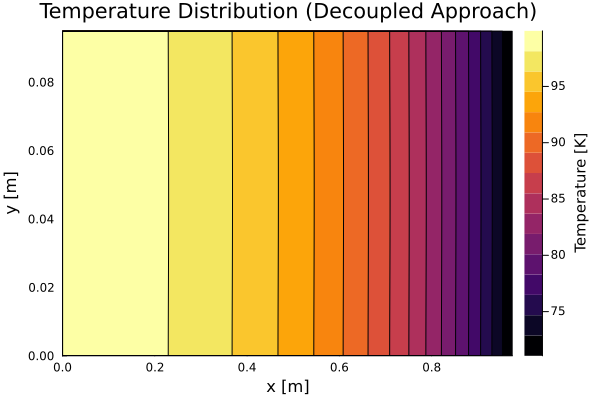

In [238]:
function assemble_temp_system!(K, dh_temp, cv_temp, dh_flow, cv_flow, flow_solution, α)
    """
    Assemble system matrix for the temperature transport equation (post-processing):
    (u⃗ · ∇)T = α ∇²T  (steady state, no heat source)
    
    This function assembles the convection-diffusion matrix for temperature transport
    using a pre-computed velocity field from the Navier-Stokes solution.
    
    Parameters:
    - K: Global system matrix for temperature (to be assembled)
    - dh_temp: DOF handler for temperature field (separate from flow)
    - cv_temp: Cell values for temperature field
    - dh_flow: DOF handler for flow field (velocity + pressure)
    - cv_flow: Cell values for velocity field
    - flow_solution: Solution vector from Navier-Stokes (contains velocity + pressure)
    - α: Thermal diffusivity [m²/s]
    """
    
    assembler = start_assemble(K)
    
    # Get DOF ranges
    range_temp = dof_range(dh_temp, :T)      # Temperature DOFs
    range_vel = dof_range(dh_flow, :v)       # Velocity DOFs from flow solution
    
    ndofs_temp = length(range_temp)
    Ke = zeros(ndofs_temp, ndofs_temp)
    
    # Shape function storage for temperature
    T_shape = Vector{Float64}(undef, ndofs_temp)
    ∇T_shape = Vector{Vec{2,Float64}}(undef, ndofs_temp)
    
    # Loop over all cells
    for (cell_num, cell) in enumerate(CellIterator(dh_temp))
        fill!(Ke, 0)
        
        # Reinitialize cell values for temperature field
        Ferrite.reinit!(cv_temp, cell)
        
        # Extract velocity DOFs for this cell from the flow solution
        vel_dofs_local = flow_solution[celldofs(dh_flow, cell_num)[range_vel]]
        
        # Loop over quadrature points
        for qp in 1:getnquadpoints(cv_temp)
            dΩ = getdetJdV(cv_temp, qp)
            
            # Get temperature shape functions and gradients
            for i in 1:ndofs_temp
                T_shape[i] = shape_value(cv_temp, qp, i)
                ∇T_shape[i] = shape_gradient(cv_temp, qp, i)
            end
            
            # Interpolate velocity at this quadrature point using flow cell values
            vel_qp = function_value(cv_flow, qp, vel_dofs_local)
            
            # Assemble element matrix
            for (i, I) in pairs(range_temp), (j, J) in pairs(range_temp)
                # Thermal diffusion term: α ∇T_i · ∇T_j
                diffusion_term = α * (∇T_shape[i] ⋅ ∇T_shape[j])
                
                # Thermal convection term: (u⃗ · ∇T_i) * T_j
                convection_term = (vel_qp ⋅ ∇T_shape[j]) * T_shape[i]
                
                
                # Add both terms to element matrix
                Ke[I, J] += (diffusion_term + 1*convection_term) * dΩ
            end
        end
        
        # Assemble element matrix into global matrix
        assemble!(assembler, celldofs(cell), Ke)
    end
    
    return K
end

# =============================================================================
# DECOUPLED TEMPERATURE TRANSPORT IMPLEMENTATION
# =============================================================================

# 1. MATERIAL PROPERTIES FOR TEMPERATURE TRANSPORT

ρ = 1.0                    # Density [kg/m³]
cp = 1005.0                # Specific heat capacity [J/(kg·K)]
k_thermal = 2500          # Thermal conductivity [W/(m·K)]
α = k_thermal / (ρ * cp)   # Thermal diffusivity [m²/s]


# 2. SEPARATE DOF HANDLER FOR TEMPERATURE (Key requirement from supervisor)
println("\n Setting up separate DOF handler for temperature:")

# Temperature finite element setup
degree_temp = 2  # Same as velocity for consistency and accuracy
ip_temp = Lagrange{RefQuadrilateral, degree_temp}()

# Temperature cell values
qr_temp = QuadratureRule{RefQuadrilateral}(4)     
cv_temp = CellValues(qr_temp, ip_temp)

# SEPARATE DOF HANDLER for temperature 
dh_temp = DofHandler(grid)                    # Same mesh, different DOF handler
add!(dh_temp, :T, ip_temp)                   
close!(dh_temp)


# 3. TEMPERATURE BOUNDARY CONDITIONS
println("\n Setting up temperature boundary conditions:")

ch_temp = ConstraintHandler(dh_temp)

# Inlet temperature boundary condition
T_inlet = 100.0  # [K] Hot fluid at inlet
# T_walls = 70.0  # [K] Wall temperature (ambient)
T_outlet = 70.0

# Inlet BC: Hot fluid injection
dbc_inlet_temp = Dirichlet(:T, inlet, x -> T_inlet)
add!(ch_temp, dbc_inlet_temp)

# # Wall BC: Fixed temperature at walls (optional - can use natural BC instead)
# walls = union(getfacetset(grid, "top"), getfacetset(grid, "bottom"))
# dbc_wall_temp = Dirichlet(:T, walls, x -> T_walls)
# add!(ch_temp, dbc_wall_temp)

dbc_outlet_temp = Dirichlet(:T, ∂Ω_free, x -> T_outlet)
add!(ch_temp, dbc_outlet_temp)  


close!(ch_temp)

# println("   Inlet temperature: $T_inlet K")
# println("   Wall temperature: $T_walls K")

# 4. CHECK FLOW SOLUTION AVAILABILITY
println("\n Checking flow solution:")

if @isdefined(st_sol)
    println("   ✓ Using time-dependent flow solution from Navier-Stokes")
    u_flow = st_sol.u[end]  # Final time step
    # println("   ✓ Flow solution vector length: $(length(u_flow))")
else
    println("   ⚠ Time-dependent solution not available")
    println("   → Computing stationary Stokes solution for demonstration")
    
    # Solve stationary Stokes for temperature demonstration
    K_stokes = allocate_matrix(dh)
    K_stokes = assemble_stokes_matrix(cellvalues_v, cellvalues_p, viscosity, K_stokes, dh)
    f_stokes = zeros(ndofs(dh))
    
    t_stat = 1.0
    update!(ch, t_stat)
    apply!(K_stokes, f_stokes, ch)
    
    u_flow = K_stokes \ f_stokes
    println("   ✓ Stationary solution computed")
end

# 5. ASSEMBLE TEMPERATURE SYSTEM
println("\n Assembling temperature transport system:")

K_temp = allocate_matrix(dh_temp, ch_temp)
f_temp = zeros(ndofs(dh_temp))  # Zero RHS (no heat source)

# Assemble using the decoupled approach
assemble_temp_system!(K_temp, dh_temp, cv_temp, dh, cellvalues_v, u_flow, α)

println("   ✓ Temperature system matrix assembled")

# Apply boundary conditions
apply!(K_temp, f_temp, ch_temp)

println("   ✓ Boundary conditions applied")

# 6. SOLVE TEMPERATURE SYSTEM
println("\n Solving temperature transport equation:")

T_solution = K_temp \ f_temp


# Custom post-processing function for temperature
function temp_postprocess(T_sol, dh_temp, cv_temp)
    area = []
    temp_values = []
    
    for (cell_num, cell) in enumerate(CellIterator(dh_temp))
        dof_range_temp = dof_range(dh_temp, :T)
        T_local = T_sol[celldofs(dh_temp, cell_num)[dof_range_temp]]
        Ferrite.reinit!(cv_temp, cell)
        
        cell_area = 0.0
        cell_temp = 0.0
        
        for qp in 1:getnquadpoints(cv_temp)
            dΩ = getdetJdV(cv_temp, qp)
            temp_contrib = function_value(cv_temp, qp, T_local)
            cell_area += dΩ
            cell_temp += temp_contrib * dΩ
        end
        
        push!(area, cell_area)
        push!(temp_values, cell_temp / cell_area)
    end
    
    temp_2d = reshape(temp_values, nels)
    return area, temp_2d
end

# Process temperature solution
area_temp, temp2d = temp_postprocess(T_solution, dh_temp, cv_temp)


# Create visualization
plot_temp = contour(xgrid[1:end-1], ygrid[1:end-1], temp2d', 
                   fill=true, 
                   title="Temperature Distribution (Decoupled Approach)",
                   xlabel="x [m]", 
                   ylabel="y [m]",
                   colorbar_title="Temperature [K]")

display(plot_temp)

# plot velocity field as well


### Comparison plot for all three approaches

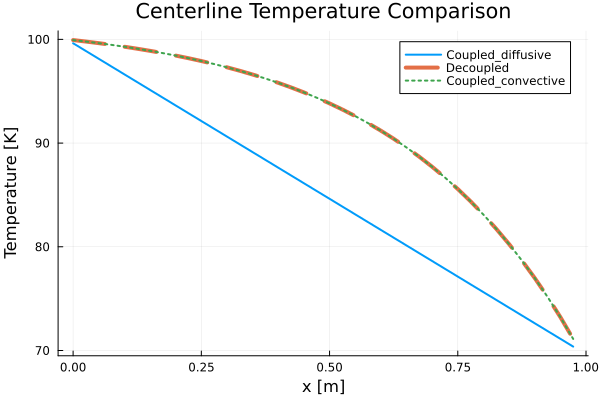

In [239]:
centerline_indices = div(nels[2], 2) + 1  # Middle row
T_centerline_coupled = temperature_2d[:, centerline_indices] 
T_centerline_convective = temperature_conv_2d[:, centerline_indices]
x_centerline = xgrid[1:end-1]
t_original_decoupled = temp2d[:, centerline_indices]


# plot comparison of the decoupled and coupled temperature along centerline
p_compare_all = plot(x_centerline, T_centerline_coupled, label="Coupled_diffusive", lw=2)
plot!(p_compare_all, x_centerline, t_original_decoupled, label="Decoupled", lw=4, ls=:dash)
plot!(p_compare_all, x_centerline, T_centerline_convective, label="Coupled_convective", lw=2, ls=:dot)
xlabel!(p_compare_all, "x [m]")
ylabel!(p_compare_all, "Temperature [K]")
title!(p_compare_all, "Centerline Temperature Comparison")
display(p_compare_all)
